In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
import time
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
'''
1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (0 for benign, 1 for malignant)
'''
# Assign the coloumn name to the data set
info = ['id','clump_thickness','cell_size','cell_shape','adhesion','singal_cell_size','bare_nuclei','bland_chromatic','nucleoli','mitoses','class']
data = pd.read_csv(url,names=info)

In [31]:
# Data Summary
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                  699 non-null int64
clump_thickness     699 non-null int64
cell_size           699 non-null int64
cell_shape          699 non-null int64
adhesion            699 non-null int64
singal_cell_size    699 non-null int64
bare_nuclei         699 non-null object
bland_chromatic     699 non-null int64
nucleoli            699 non-null int64
mitoses             699 non-null int64
class               699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


,id,clump_thickness,cell_size,cell_shape,adhesion,singal_cell_size,bland_chromatic,nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [32]:
# bare_nuclie in object format, need to convert to int but let's first check
# bare_nuclie colmn
pd.value_counts(data['bare_nuclei'].values, sort=False)

1     402
3      28
2      30
5      30
4      19
7       8
6       4
9       9
8      21
?      16
10    132
dtype: int64

In [33]:
# Contains some invalid data points - '?'
# remove those rows
data = data.drop(data[data.bare_nuclei == '?'].index, inplace=False)

In [34]:
data['bare_nuclei'] = data['bare_nuclei'].apply(lambda x: int(x) if x == x else 0)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
id                  683 non-null int64
clump_thickness     683 non-null int64
cell_size           683 non-null int64
cell_shape          683 non-null int64
adhesion            683 non-null int64
singal_cell_size    683 non-null int64
bare_nuclei         683 non-null int64
bland_chromatic     683 non-null int64
nucleoli            683 non-null int64
mitoses             683 non-null int64
class               683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


In [35]:
# convert class 2 to zero and 4 to 1
data['class'].values[data['class'].values==2]=0
data['class'].values[data['class'].values==4]=1


In [37]:
colmn = ['clump_thickness','cell_size','cell_shape','adhesion','singal_cell_size','bare_nuclei','bland_chromatic','nucleoli','mitoses']
filter_data = data[colmn]

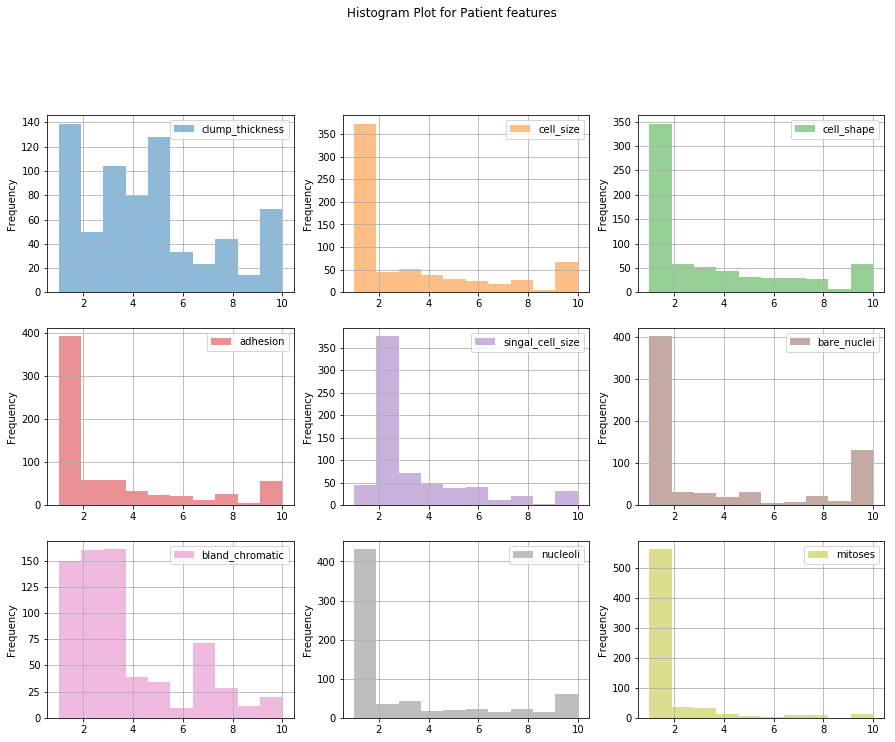

In [38]:
# Histogram plot for features
filter_data.plot(kind='hist',subplots=True, layout=(4,3), figsize=(15,15),sharex=False,alpha=.5,grid = True,
                 title="Histogram Plot for Patient features")
plt.show()

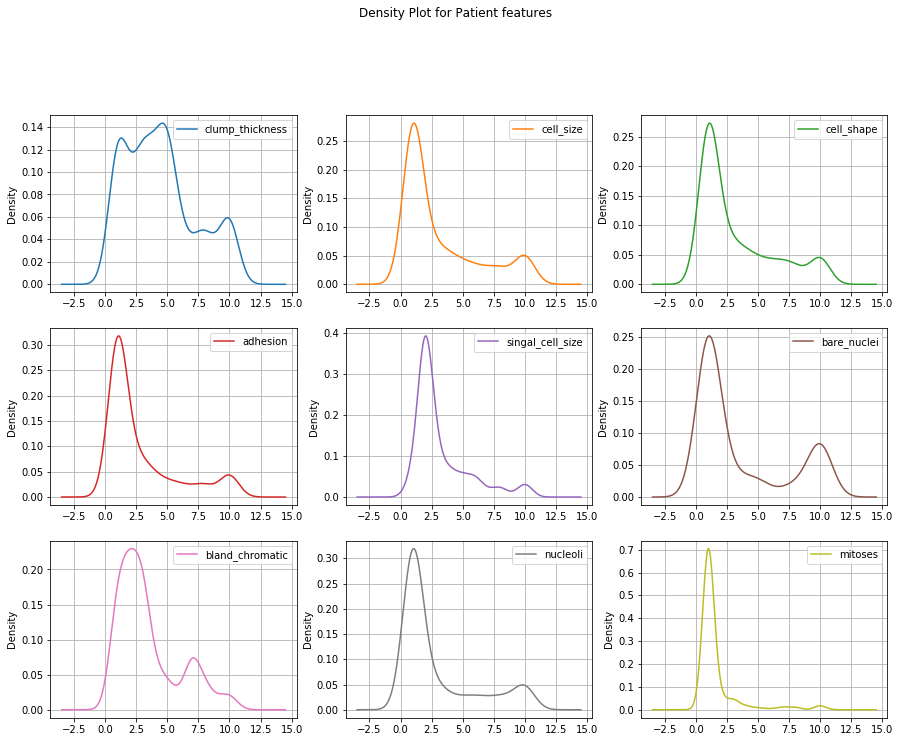

In [19]:
# Density plot for features
filter_data.plot(kind='density', subplots=True, layout=(4,3),figsize=(15,15), sharex=False,grid = True,
                title="Density Plot for Patient features")
plt.show()


In [41]:
# Correleation between different variable 
correlations = filter_data.corr()

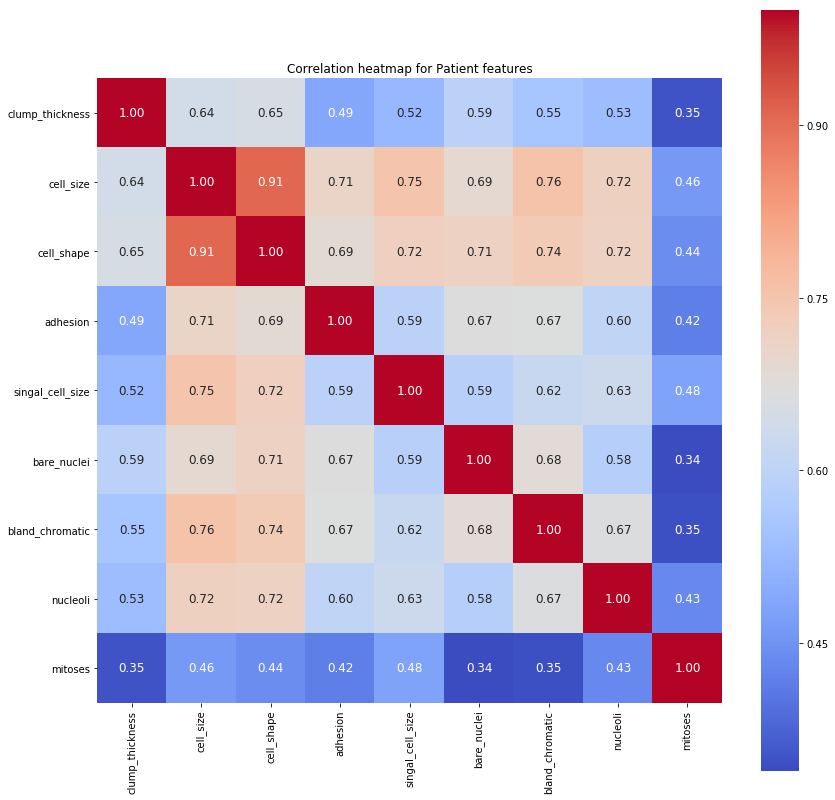

In [47]:
# plot correlation matrix

plt.figure(figsize=(14,14))
plt.title("Correlation heatmap for Patient features")
temp = sns.heatmap(correlations, cbar = True,  square = True, annot=True, 
            fmt= '.2f',annot_kws={'size': 12}, cmap= 'coolwarm') 
plt.show()

In [48]:
# So cell_size and cell_shape are highly correleated, remove one of them
# cell_shape removed
new_colmn = ['clump_thickness','cell_size','adhesion','singal_cell_size','bare_nuclei','bland_chromatic','nucleoli','mitoses']
filter_data_new = data[colmn]


In [49]:
# Now let's build one classifer to predict the patience class Benign (class 0) or malignant (class 1)

# Lets use logistic regression, here input wiold be patience features and output is cancer class

X = data[['clump_thickness','cell_size','adhesion','singal_cell_size','bare_nuclei','bland_chromatic','nucleoli','mitoses']]
y = data[['class']]
X = X.get_values()
y = y.get_values().flatten()


In [50]:
# Initilize classifer parameters, to fin out the optimal hyper parameter
# C is the inverse of the reqularization
# here is more detail https://people.eecs.berkeley.edu/~russell/classes/cs194/f11/lectures/CS194%20Fall%202011%20Lecture%2004.pdf
C = []
a = .01
while(a<=10):
    C.append(round(a,2))
    a = 2*a

parameters = {'solver':['liblinear'] , 'fit_intercept':[True,False] , 'C':C}
# So number of combination is 20

In [51]:
# Exaustive search over the parameters combinations, to get the optimal reults
# more details here http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
clf = GridSearchCV(LogisticRegression(), parameters,n_jobs=8,pre_dispatch = 4,verbose=2)
clf.fit(X, y)
result =clf.cv_results_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    1.0s finished


In [54]:
# Get the hyper parameter gives the best classifer performance
temp = {'train_score': result['mean_train_score'], 'test_score': result['mean_test_score'],'parameter':result['params']}
result_matx = pd.DataFrame(data=temp)
print(result_matx[['test_score','train_score']].max(axis=0))
# So train and test score are comparalbe, so classifier is working great, Now lets find out 
# the value of hpyer parameter corresponding to those values
index_ = result_matx[['test_score','train_score']].idxmax(axis=0).values[0]
parameters = result_matx[['parameter']][index_:index_+1].values[0][0]
# best hyper parameters
print(parameters)


test_score     0.969253
train_score    0.972923
dtype: float64
{'C': 2.56, 'solver': 'liblinear', 'fit_intercept': True}


In [57]:
# So the test and train score is almost nearby and above .96, so can safely assume that no over/under fitting
# Lets use those parameters to find out the classifier statistics like precision, recall and confusion to further fine tune parameters
# training and test data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=42)

# utilizing those weights to train a classifier to find out the confusion matrix

# use the parameters to train a classifier again
clf_lr = LogisticRegression(C=parameters['C'],max_iter =1000,random_state=10,tol=1e-4,n_jobs= -1,fit_intercept=parameters['fit_intercept'])
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
score_ = accuracy_score(y_test, y_pred_lr,normalize=True)
CLASS_NAME  = ["Benign","Malignant"]
print(classification_report(y_pred_lr, y_test, target_names=CLASS_NAME))

             precision    recall  f1-score   support

     Benign       0.99      0.95      0.97       181
  Malignant       0.91      0.98      0.94        93

avg / total       0.96      0.96      0.96       274



Confusion matrix, without normalization


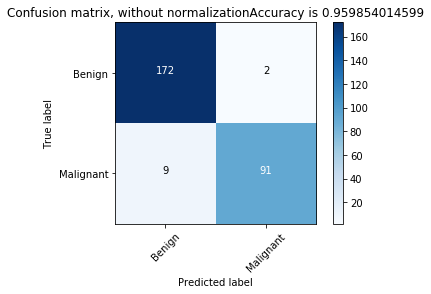

In [64]:
# Confusion matrix 

def plt_confusion_matrix(y_pred,y_test,accuracy):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    CLASS_NAME  = ["Benign","Malignant"]
    # Plot non-normalized confusion matrix
    title_= 'Confusion matrix, without normalization' + "Accuracy is "+ str(accuracy)
    plot_confusion_matrix(cnf_matrix, classes=CLASS_NAME,title=title_)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt_confusion_matrix(y_pred_lr,y_test,score_)
plt.show()

In [ ]:
# as seen above the recall value for the Malignant is quite good, only 2 of person is being predicted
# as benign despite of malignant. And this is want we want. So classifier model is doing quite good.